In [1]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from inspect_tables import (targhe, timestamp_names, plate_names,
                            veicoli, fatture, plot_date_relplot,
                            read_data, overview, draw_report, draw_correlation)

pd.options.display.max_columns = 100

%matplotlib inline

Excel files can be downloaded
 - Veicoli: [[here](https://docs.google.com/spreadsheets/d/1KoSnpYXO4Roeg1nOscIsg4m6jvHN60k2/edit?usp=sharing&ouid=100767706223000279509&rtpof=true&sd=true)]
 - Fatture: [[here](https://teams.microsoft.com/l/file/2C9DF49B-8E52-438C-BEC5-F932517E22D0?tenantId=2a05ac92-2049-4a26-9b34-897763efc8e2&fileType=xlsx&objectUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks%2FShared%20Documents%2FGeneral%2FAnalisi%2Feventi_manutenzioni_esterne%20(da%20fatture).xlsx&baseUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks&serviceName=teams&threadId=19:uchivw6_oRyy6ipbNZlMKqkJWjGS5PxW2PGkqRwyvPE1@thread.tacv2&groupId=540e54c7-2583-4176-bcda-2ca674542369)]

# Data cleaning - [MOVIMATICA](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/MOVIMATICA)

In [2]:
df_MOV_vehicles = read_data("dataset/MOVIMATICA_vehicles.csv", cut_range=True)
# df_MOV_vehicles["position_date"] = df_MOV_vehicles.timestamp.dt.date
df_MOV_vehicles.head()

Eliminati 1272 record anomali antecedenti al 2021 (in date 03/10/2020)


,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,timestamp
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,4514,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,30349,ZB478AN,45.960472,8.421074,1060885110,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,12,2021-05-11T09:34:28+02:00,digital_input_change,Cambio Digital IN,TIS213369/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11 07:34:28
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,4426,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,37532,ZB476AN,45.960022,8.420602,1061115070,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-05-11T11:26:41+02:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11 09:26:41
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,3497,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,24933,ZB477AN,41.784200,12.301565,1061114233,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,1,2021-05-11T11:20:15+02:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11 09:20:15
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1395,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,63197,ZB127AR,44.585390,7.902978,1061318067,False,Località Piano 5,IT,Italia,Novello,Piemonte,12060.0,0,2021-05-11T12:40:38+02:00,external_power_on,Alimentazione ripristinata,TIS433613/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11 10:40:38
6,0,NaN,0,NONE,NaN,D6220,Scania,TIMP44648/18,NaN,959,0,NaN,False,9741,True,False,disabled,P320,Scania P320,11308,FV914SK,45.947212,10.905164,1061560745,False,Località Matoni 1,IT,Italia,Dro,Trentino-Alto Adige,38074.0,1,2021-05-11T15:08:58+02:00,external_power_on,Alimentazione ripristinata,TIMP44648/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11 13:08:58


## Check ripetizioni

In [12]:
important = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.date<pd.Timestamp("2021-09-01")]
gpb = important.groupby(["plate", "position_timestamp"]).sav.count()
anom_plates = gpb[gpb>20].index.get_level_values(0).unique()
anom_date = gpb.reset_index().groupby("plate").position_timestamp.first()

AttributeError: Can only use .dt accessor with datetimelike values

In [34]:
check = []
for pl, g in important[important.plate.isin(anom_plates)].groupby(["plate"]):
    date_after = g[g.position_timestamp > anom_date[pl]].position_timestamp.min()
    check.append([
        pl,
        anom_date[pl],
        g[g.position_timestamp == anom_date[pl]].odometer.min(),
        date_after,
        g[g.position_timestamp == date_after].odometer.min()
    ])
    
Anomalies = pd.DataFrame(check, columns=["plate", "an_date", "km_an", "date_after", "km_after"])

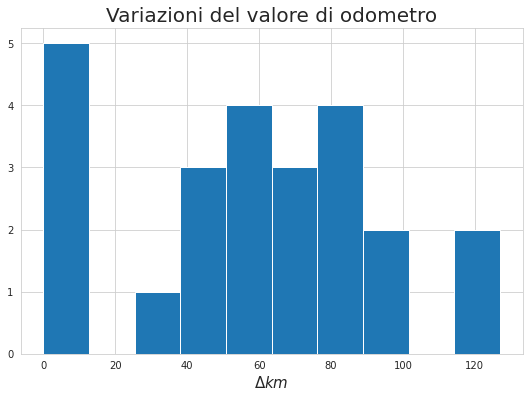

In [6]:
Anomalies["delta_date"] = Anomalies.date_after - Anomalies.an_date
Anomalies["delta_km"] = Anomalies.km_after - Anomalies.km_an
ax = Anomalies[["delta_date", "delta_km"]].delta_km.hist(figsize=(9,6))
ax.set_xlabel("$\Delta km$", size=15)
ax.set_title("Variazioni del valore di odometro", size=20)
plt.show()

In [54]:
tm = df_MOV_vehicles.groupby(["plate", "position_timestamp"], as_index=False).count()#.index

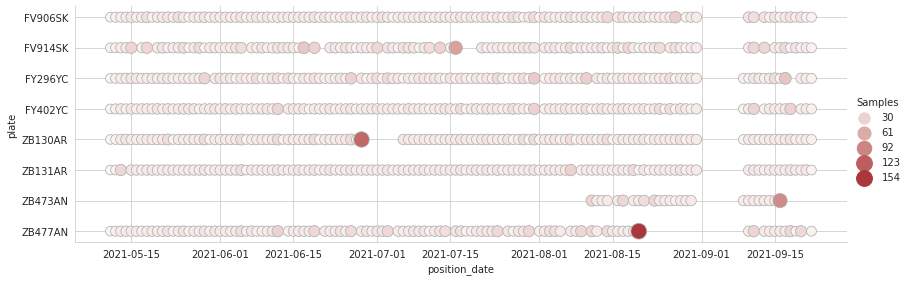

In [61]:
tmp = df_MOV_vehicles[(df_MOV_vehicles.position_timestamp.dt.year == 2021)&(df_MOV_vehicles.plate.isin(tm[tm.box>28].plate))].sort_values(by="position_date").groupby(["plate", "position_date"], as_index=False).box.count()

tmp['c'] = tmp.box / tmp.box.max()
g = sns.relplot(
    data=tmp,
    x="position_date", y="plate", hue="c", size="c",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=4, sizes=(50, 250), size_norm=(-.2, .8), aspect=3
)
# plt.scatter(data=view_fatture, x="Apertura_commessa", y="Targa", marker="d", s=100, c="lightblue", edgecolors="grey")

for t in g._legend.get_texts():
    t.set_text(int(float(t.get_text())*tmp.box.max()))
g._legend.set_title("Samples")

In [8]:
tmp = df_MOV_vehicles[(df_MOV_vehicles.plate=="FV914SK")\
                      &(df_MOV_vehicles.position_timestamp.dt.date > pd.Timestamp("2021-07-15"))\
                      &(df_MOV_vehicles.position_timestamp.dt.date < pd.Timestamp("2021-08-01"))].reset_index(drop=True)

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [9]:
from matplotlib import dates

No handles with labels found to put in legend.


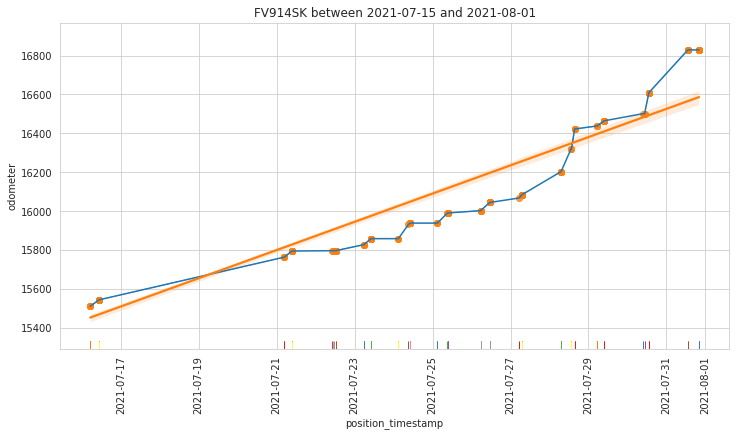

In [10]:
fig, g = plt.subplots(figsize=(12,6))

# @pyplot.FuncFormatter
# def fake_dates(x, pos):
#     """ Custom formater to turn floats into e.g., 2016-05-08"""
#     return dates.num2date(x).strftime('%Y-%m-%d')

sns.lineplot(data=tmp, x="position_timestamp", y="odometer", ax=g)
sns.regplot(data=tmp, x=dates.date2num(tmp.position_timestamp), y="odometer", ax=g)
# sns.lineplot(data=tmp, x="position_timestamp", y="engineHours", ax=g, color="violet")
g.set_title("FV914SK between 2021-07-15 and 2021-08-01")
sns.rugplot(data=tmp, x="position_timestamp", hue="filename", ax=g, legend=False, palette="Set1")
g.legend().remove()
g.tick_params(axis='x', rotation=90)

---
## Overview

In [3]:
df_MOV_vehicles, u_c = overview(df_MOV_vehicles)

    Dati raccolti tra 05/2021 e 09/2021
    40 parametri totali monitorati
    58752 record nel datalake
    12935 record non ripetuti
    34 truck di interesse monitorati
    In media 1728.0 misurazioni per ogni mezzo su 5 mesi
    In media 12.8 misurazioni/giorno/mezzo (dettaglio successivamente)
    284 fatture associate.

Misurazioni con valore singolo:
alarm_tipology_label                     NaN
customId                                 NaN
fleet_id                                   0
fleet_ilabel                             NaN
hasTelemetry                           False
lock_enabled                            True
lock_locked                            False
lock_status                         disabled
position_place_country_id                 IT
position_place_country_label          Italia
typology_id                        COMPACTOR
typology_label                  Compattatore
Name: 0, dtype: object
--> Colonne eliminate


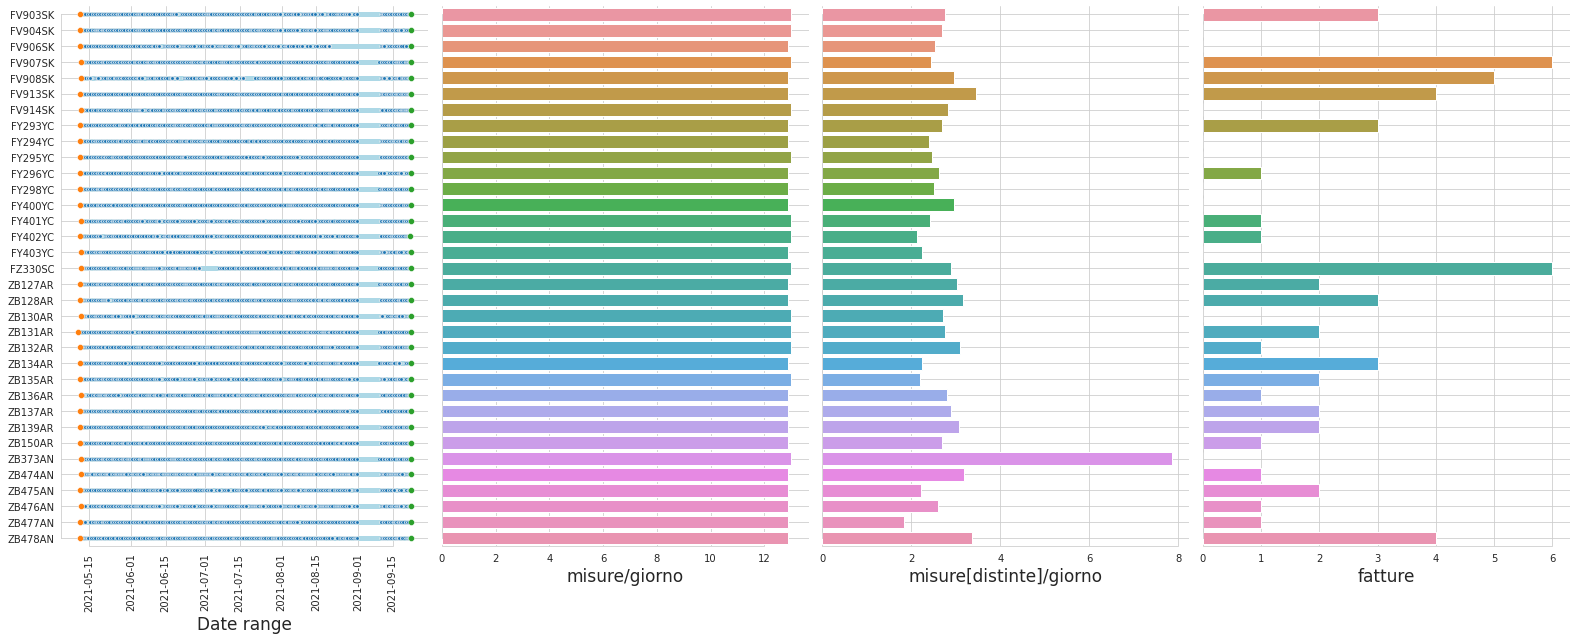

In [4]:
draw_report(df_MOV_vehicles.drop("filename", axis=1))

In [15]:
df_MOV_vehicles = df_MOV_vehicles.drop("filename", axis=1).drop_duplicates()

---
## Monotonia

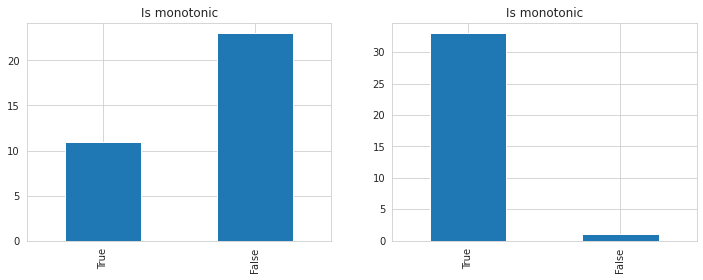

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_MOV_vehicles.groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title="Is monotonic", ax=ax[0])
df_MOV_vehicles.groupby('plate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Is monotonic", ax=ax[1])
plt.show()

KeyboardInterrupt: 

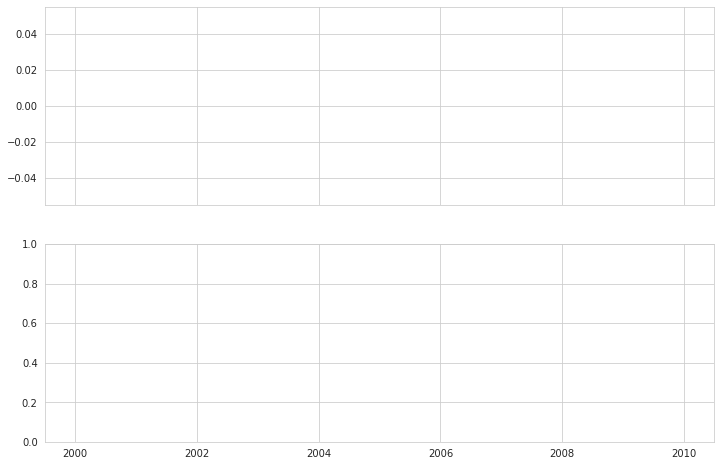

In [17]:
tmp = df_MOV_vehicles[df_MOV_vehicles.groupby('plate').odometer.transform(lambda x: not x.is_monotonic_increasing)]
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.lineplot(data=tmp, x="timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp, x="timestamp", hue="plate", ax=ax[0])

sns.lineplot(data=tmp, x="timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp, x="timestamp", hue="plate", ax=ax[1])

for i, (plate, d) in enumerate(tmp.groupby('plate')[["timestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="timestamp", y="odometer", markers="*", s=100)
    plt.text(x=d[d.df<0].timestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,9), sharex=True)
tmp2 = df_MOV_vehicles[(df_MOV_vehicles.groupby('plate').engineHours.transform(lambda x: not x.is_monotonic_increasing))&(df_MOV_vehicles.timestamp.dt.year == 2021)]
sns.lineplot(data=tmp2, x="timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp2, x="timestamp", hue="plate", ax=ax[0])

ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.15,0))

sns.lineplot(data=tmp2, x="timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp2, x="timestamp", hue="plate", ax=ax[1])

sns.despine(trim=True, left=True)
ax[1].get_legend().remove()
plt.show()

In [ ]:
df_MOV_vehicles[df_MOV_vehicles.timestamp.dt.date<pd.to_datetime("2021-09-01")].groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_index(ascending=False)#.plot(kind="bar", title="Is monotonic (before 2021-09-01)")
# plt.show()

---
## Analisi Misurazioni giornaliere

In [18]:
view_fatture = fatture[(fatture.Targa.isin(df_MOV_vehicles.plate.unique()))&\
                       (fatture.Apertura_commessa.dt.date>=df_MOV_vehicles.timestamp.min().date())&\
                       (fatture.Apertura_commessa.dt.date<=df_MOV_vehicles.timestamp.max().date())]

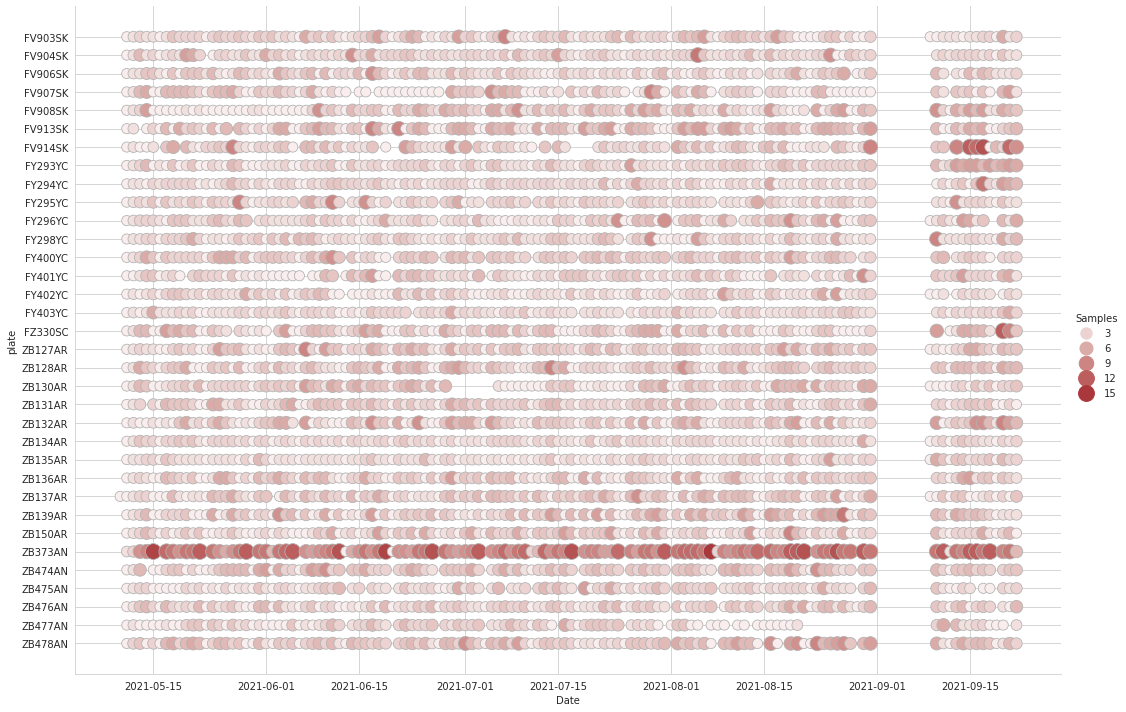

In [20]:
plot_date_relplot(df_MOV_vehicles)

In [21]:
df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"].position_typology_id.value_counts().to_frame()

,position_typology_id
digital_input_change,847
motion_stop,193
position,3
external_power_on,1


KeyboardInterrupt: 

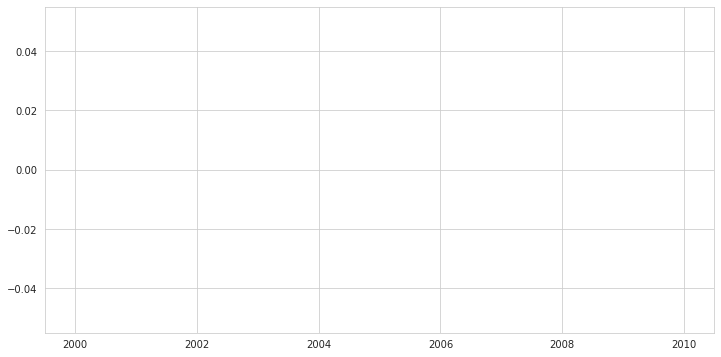

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
             x="timestamp",
             y="odometer",
             ax=ax
            )

sns.scatterplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
                x="timestamp",
                y="odometer",
                hue="position_typology_id",
                style="position_typology_id",
                ax=ax,
                zorder=4,
                s=20
               )
sns.rugplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
            x="timestamp",
            hue="position_typology_id"
           )
ax.set_title("Odometer for ZB373AN")
plt.show()

In [ ]:
# TO FIX!
tmp = df_MOV_vehicles.groupby(['plate', "position_date"]).engineHours.count().reset_index()
g = sns.FacetGrid(tmp, row="plate", aspect=2)
g.map(sns.barplot, "position_date", "engineHours")

---
## Correlation

In [20]:
df_MOV_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,position_date
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,4514,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,30349,ZB478AN,45.960472,8.421074,1060885110,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,12,2021-05-11 07:34:28+00:00,digital_input_change,Cambio Digital IN,TIS213369/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,4426,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,37532,ZB476AN,45.960022,8.420602,1061115070,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-05-11 09:26:41+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,3497,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,24933,ZB477AN,41.784200,12.301565,1061114233,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,1,2021-05-11 09:20:15+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1395,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,63197,ZB127AR,44.585390,7.902978,1061318067,False,Località Piano 5,IT,Italia,Novello,Piemonte,12060.0,0,2021-05-11 10:40:38+00:00,external_power_on,Alimentazione ripristinata,TIS433613/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
6,0,NaN,0,NONE,NaN,D6220,Scania,TIMP44648/18,NaN,959,0,NaN,False,9741,True,False,disabled,P320,Scania P320,11308,FV914SK,45.947212,10.905164,1061560745,False,Località Matoni 1,IT,Italia,Dro,Trentino-Alto Adige,38074.0,1,2021-05-11 13:08:58+00:00,external_power_on,Alimentazione ripristinata,TIMP44648/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11


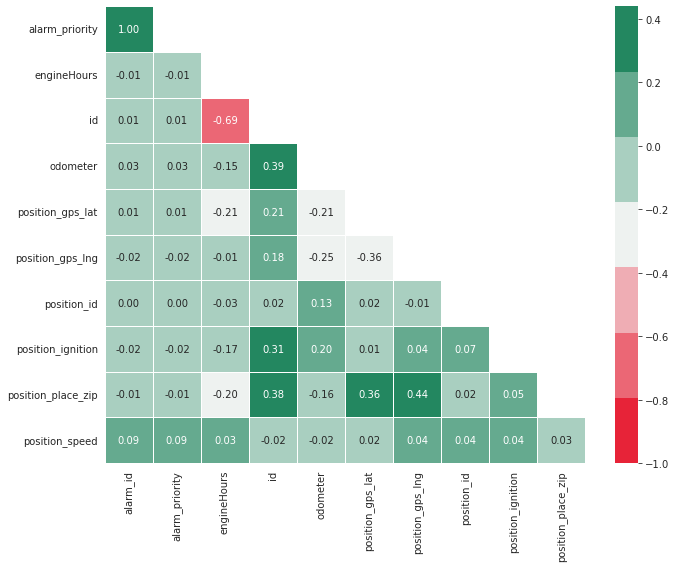

In [25]:
pseudo_plate = [c for c in df_MOV_vehicles.columns if len(df_MOV_vehicles[c].unique()) == 35]
g = draw_correlation(df_MOV_vehicles.drop(pseudo_plate, axis=1))

---
## PCA

In [179]:
data_std.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')]).index

Index(['odometer', 'engineHours', 'position_speed', 'position_ignition'], dtype='object')

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_MOV_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_MOV_vehicles[["odometer", "engineHours", "position_speed", "position_ignition"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,odometer,engineHours,position_speed,position_ignition
119,-1.306122,-0.714378,-0.293483,-0.827088
35316,-1.306122,-0.714378,-0.293483,-0.827088
63045,0.927527,-0.852566,-0.293483,-0.827088
35269,1.773145,-0.711330,-0.293483,1.209062
35272,-0.963058,-0.809890,-0.151331,-0.827088


In [182]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [183]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.33576503, 0.25413525, 0.21557315, 0.19452656])

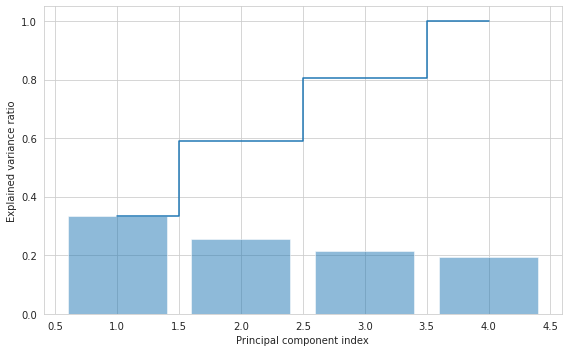

In [184]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [165]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [167]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [168]:
most_important_names

{0: ['odometer', 'position_place_zip', 'position_gps_lng'],
 1: ['position_gps_lng', 'engineHours', 'position_gps_lat'],
 2: ['position_gps_lng', 'position_ignition', 'position_gps_lat'],
 3: ['position_id', 'alarm_priority', 'position_speed'],
 4: ['engineHours', 'alarm_priority', 'position_id'],
 5: ['position_ignition', 'alarm_priority', 'position_speed']}

**position_place_zip??**

In [ ]:

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")
fatture.Apertura_commessa = pd.to_datetime(fatture.Apertura_commessa)